In [32]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json
import re

Pull in the processed inventory

In [33]:
ra = "pacioos"

#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).


ra_clean = re.sub(r'[0-9]', '', ra) # remove number from RA 

df = pd.read_excel('2024/data/processed/%s.xlsx' % ra_clean.upper(), dtype=str)
df.head()

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,PACIOOS,AWS-HIMB,NaN,Coconut Island Weather Station,NaN,21.433,-157.7863,fixed,2005-01-01 00:00:00,Y,NaN,N,Hawaii Institute of Marine Biology,Academic,Hawaii Institute of Marine Biology,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.
1,PACIOOS,WS- Pier 1,NaN,Pier 1 Honolulu Weather Station,Davis Weather Station,21.2962,-157.8687,fixed,2019-08-14 00:00:00,Y,Hawaii Pilot's Assoc.,N,PacIOOS,Private/Academic,PacIOOS,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.
2,PACIOOS,CDIP 098,51202,"Mokapu Point, Oahu, Hawaii",Datawell Waverider,21.415,-157.6783,wave_buoy,2000-08-09 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN
3,PACIOOS,CDIP 106,51201,"Waimea Bay, Oahu, Hawaii",Datawell Waverider,21.6705,-158.1172,wave_buoy,2001-12-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN
4,PACIOOS,CDIP 121,52200,"Ipan, Guam",Datawell Waverider,13.3542,144.7883,wave_buoy,2003-07-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN


## Check column headers

The official column headers are found in the README at https://github.com/ioos/ioos-asset-inventory/tree/main. This checks the column headers from the RA inventory against our official column headers to see if anything is missing. The result will print out what columns are missing from the RA inventory and what columns the RA added to their inventory.

In [34]:
url = 'https://github.com/ioos/ioos-asset-inventory/tree/main'

import pandas as pd

df_fields = pd.read_html(url)#

control_fields = df_fields[2]['Field'].tolist()


def diff(a, b):
  if len(set(a) - set(b)) > 0:
    print(f"Columns missing: {set(a) - set(b)}")
  if len(set(b) - set(a)) > 0:
    print(f"Columns added: {set(b) - set(a)}")
  if set(a) == set(b):
    print(f"They are the same")

diff(control_fields, df.columns.tolist())

They are the same


Make a plot of all points.

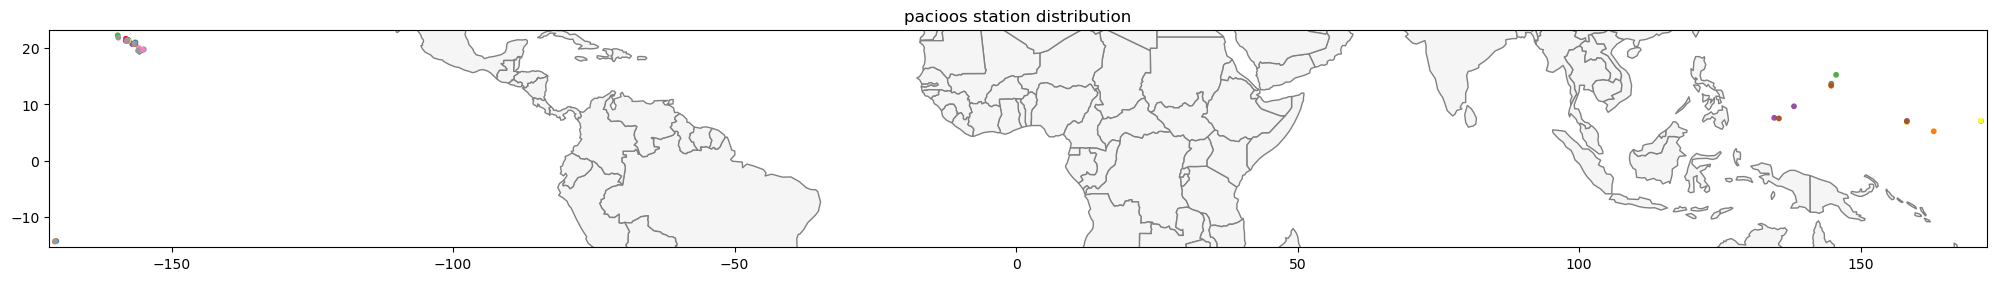

In [35]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [36]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore()#'erddap_avail',cmap = 'Set1')


Configure the ERDDAP to search

In [37]:
with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

https://pae-paha.pacioos.hawaii.edu/erddap


Search the ERDDAP server for a single station of interest - more of a test

In [38]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [39]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [40]:
not_found = []
found = dict()

exclude = ' -gliders'


if ra == 'glos':
    search_order = ['Dataset (ERDDAP) ID','Station ID', 'Station Long Name']
elif ra == 'sccoos':
    search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']
else:
    search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

for search1 in df[search_order[0]].astype(str):

    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        for dset_id in resp['Dataset ID'].values.tolist():
            if search1.lower() in dset_id.lower():
                found[search1] = {'Dataset ID': [dset_id]}
                print("Keeping \"%s\": %s" % (search1,dset_id))
                #found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station ID" = "AWS-HIMB"
no dataset matching "AWS-HIMB"
searching "Station Long Name" = "Coconut Island Weather Station"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "WS- Pier 1"
no dataset matching "WS- Pier 1"
searching "Station Long Name" = "Pier 1 Honolulu Weather Station"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "CDIP 098"
no dataset matching "CDIP 098"
searching "Station Long Name" = "Mokapu Point, Oahu, Hawaii"
searching "WMO ID or NWS/CMAN ID" = "51202"
Couldn't find: ['CDIP 098', 'Mokapu Point, Oahu, Hawaii', '51202']


searching "Station ID" = "CDIP 106"
no dataset matching "CDIP 106"
searching "Station Long Name" = "Waimea Bay, Oahu, Hawaii"
searching "WMO ID or NWS/CMAN ID" = "51201"
Couldn't find: ['CDIP 106', 'Waimea Bay, Oahu, Hawaii', '51201']


searching "Station ID" = "CDIP 121"
no dataset matching "CDIP 121"
searching "Station Long Name" = "Ipan, Guam"
searching "WMO ID or NWS/CMAN ID" = "52200"
Couldn't 

Print the stations that we couldn't find.

In [41]:
len(not_found)

45

In [42]:
len(found)

0

Show me the record that has NaN for the first search element.

In [43]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry


Now show me the stations, with identifiers, that we couldn't find.

In [44]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry
0,PACIOOS,AWS-HIMB,NaN,Coconut Island Weather Station,NaN,21.433,-157.7863,fixed,2005-01-01 00:00:00,Y,NaN,N,Hawaii Institute of Marine Biology,Academic,Hawaii Institute of Marine Biology,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.,POINT (-157.78630 21.43300)
1,PACIOOS,WS- Pier 1,NaN,Pier 1 Honolulu Weather Station,Davis Weather Station,21.2962,-157.8687,fixed,2019-08-14 00:00:00,Y,Hawaii Pilot's Assoc.,N,PacIOOS,Private/Academic,PacIOOS,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.,POINT (-157.86870 21.29620)
2,PACIOOS,CDIP 098,51202,"Mokapu Point, Oahu, Hawaii",Datawell Waverider,21.415,-157.6783,wave_buoy,2000-08-09 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-157.67830 21.41500)
3,PACIOOS,CDIP 106,51201,"Waimea Bay, Oahu, Hawaii",Datawell Waverider,21.6705,-158.1172,wave_buoy,2001-12-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-158.11720 21.67050)
4,PACIOOS,CDIP 121,52200,"Ipan, Guam",Datawell Waverider,13.3542,144.7883,wave_buoy,2003-07-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (144.78830 13.35420)
5,PACIOOS,CDIP 163,52201,"Kalo, Majuro, Marshall Islands",Datawell Waverider,7.0835,171.3918,wave_buoy,2016-05-04 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (171.39180 7.08350)
6,PACIOOS,CDIP 187,51205,"Pauwela, Maui, Hawaii",Datawell Waverider,21.0182,-156.4252,wave_buoy,2011-12-03 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-156.42520 21.01820)
7,PACIOOS,CDIP 188,51206,"Hilo, Hawaii",Datawell Waverider,19.78,-154.97,wave_buoy,2012-03-04 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Due to be redeployed in May 2024;,POINT (-154.97000 19.78000)
8,PACIOOS,CDIP 189,51209,"Aunuu, American Samoa",Datawell Waverider,-14.2645,-170.4934,wave_buoy,2014-10-23 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Due to be redeployed in May 2024;,POINT (-170.49340 -14.26450)
9,PACIOOS,CDIP 196,52202,"Ritidian Point, Guam",Datawell Waverider,13.6837,144.8121,wave_buoy,2012-10-20 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Replacement buoy on-site. Waiting on weather ...,POINT (144.81210 13.68370)


Print out all the dataset IDs for the datasets that matched our criteria.

In [45]:
found

{}

Check if each found dataset has coverage for specified CY

In [46]:
valid_datasets = []

cy = '2024'
n=0
for key in found:
    
    print(f'testing {key}')
    
    dataset_id = found[key]['Dataset ID'] #+" "+found[key]['Station ID']
    
    if (len(dataset_id)>1):
        
        for dataset in dataset_id:
            n+=1
            if (n<3):
                e.dataset_id = dataset
        
                e.constraints = {
                    "time>=": "{}-01-01".format(cy)
                }
            
                e.variables = ['time']
        
                try:
                    df_data = e.to_pandas(parse_dates=True)
                    valid_datasets.extend([key])
                    
                except:

                    print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))

                    pass

                

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:

            print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))
            
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

Datasets without coverage for 2024:
set()


Show me the inventory metadata about the invalid stations:

In [47]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_not_avail
0,PACIOOS,AWS-HIMB,NaN,Coconut Island Weather Station,NaN,21.433,-157.7863,fixed,2005-01-01 00:00:00,Y,NaN,N,Hawaii Institute of Marine Biology,Academic,Hawaii Institute of Marine Biology,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.,POINT (-157.78630 21.43300),True
1,PACIOOS,WS- Pier 1,NaN,Pier 1 Honolulu Weather Station,Davis Weather Station,21.2962,-157.8687,fixed,2019-08-14 00:00:00,Y,Hawaii Pilot's Assoc.,N,PacIOOS,Private/Academic,PacIOOS,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.,POINT (-157.86870 21.29620),True
2,PACIOOS,CDIP 098,51202,"Mokapu Point, Oahu, Hawaii",Datawell Waverider,21.415,-157.6783,wave_buoy,2000-08-09 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-157.67830 21.41500),True
3,PACIOOS,CDIP 106,51201,"Waimea Bay, Oahu, Hawaii",Datawell Waverider,21.6705,-158.1172,wave_buoy,2001-12-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-158.11720 21.67050),True
4,PACIOOS,CDIP 121,52200,"Ipan, Guam",Datawell Waverider,13.3542,144.7883,wave_buoy,2003-07-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (144.78830 13.35420),True
5,PACIOOS,CDIP 163,52201,"Kalo, Majuro, Marshall Islands",Datawell Waverider,7.0835,171.3918,wave_buoy,2016-05-04 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (171.39180 7.08350),True
6,PACIOOS,CDIP 187,51205,"Pauwela, Maui, Hawaii",Datawell Waverider,21.0182,-156.4252,wave_buoy,2011-12-03 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-156.42520 21.01820),True
7,PACIOOS,CDIP 188,51206,"Hilo, Hawaii",Datawell Waverider,19.78,-154.97,wave_buoy,2012-03-04 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Due to be redeployed in May 2024;,POINT (-154.97000 19.78000),True
8,PACIOOS,CDIP 189,51209,"Aunuu, American Samoa",Datawell Waverider,-14.2645,-170.4934,wave_buoy,2014-10-23 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Due to be redeployed in May 2024;,POINT (-170.49340 -14.26450),True
9,PACIOOS,CDIP 196,52202,"Ritidian Point, Guam",Datawell Waverider,13.6837,144.8121,wave_buoy,2012-10-20 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Replacement buoy on-site. Waiting on weather ...,POINT (144.81210 13.68370),True


Invert the `erddap_not_avail` column and drop it.

In [48]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
0,PACIOOS,AWS-HIMB,NaN,Coconut Island Weather Station,NaN,21.433,-157.7863,fixed,2005-01-01 00:00:00,Y,NaN,N,Hawaii Institute of Marine Biology,Academic,Hawaii Institute of Marine Biology,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.,POINT (-157.78630 21.43300),False
1,PACIOOS,WS- Pier 1,NaN,Pier 1 Honolulu Weather Station,Davis Weather Station,21.2962,-157.8687,fixed,2019-08-14 00:00:00,Y,Hawaii Pilot's Assoc.,N,PacIOOS,Private/Academic,PacIOOS,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.,POINT (-157.86870 21.29620),False
2,PACIOOS,CDIP 098,51202,"Mokapu Point, Oahu, Hawaii",Datawell Waverider,21.415,-157.6783,wave_buoy,2000-08-09 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-157.67830 21.41500),False
3,PACIOOS,CDIP 106,51201,"Waimea Bay, Oahu, Hawaii",Datawell Waverider,21.6705,-158.1172,wave_buoy,2001-12-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-158.11720 21.67050),False
4,PACIOOS,CDIP 121,52200,"Ipan, Guam",Datawell Waverider,13.3542,144.7883,wave_buoy,2003-07-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (144.78830 13.35420),False
5,PACIOOS,CDIP 163,52201,"Kalo, Majuro, Marshall Islands",Datawell Waverider,7.0835,171.3918,wave_buoy,2016-05-04 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (171.39180 7.08350),False
6,PACIOOS,CDIP 187,51205,"Pauwela, Maui, Hawaii",Datawell Waverider,21.0182,-156.4252,wave_buoy,2011-12-03 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-156.42520 21.01820),False
7,PACIOOS,CDIP 188,51206,"Hilo, Hawaii",Datawell Waverider,19.78,-154.97,wave_buoy,2012-03-04 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Due to be redeployed in May 2024;,POINT (-154.97000 19.78000),False
8,PACIOOS,CDIP 189,51209,"Aunuu, American Samoa",Datawell Waverider,-14.2645,-170.4934,wave_buoy,2014-10-23 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Due to be redeployed in May 2024;,POINT (-170.49340 -14.26450),False
9,PACIOOS,CDIP 196,52202,"Ritidian Point, Guam",Datawell Waverider,13.6837,144.8121,wave_buoy,2012-10-20 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Replacement buoy on-site. Waiting on weather ...,POINT (144.81210 13.68370),False


Make a plot of all points and color based on ERDDAP available or not.

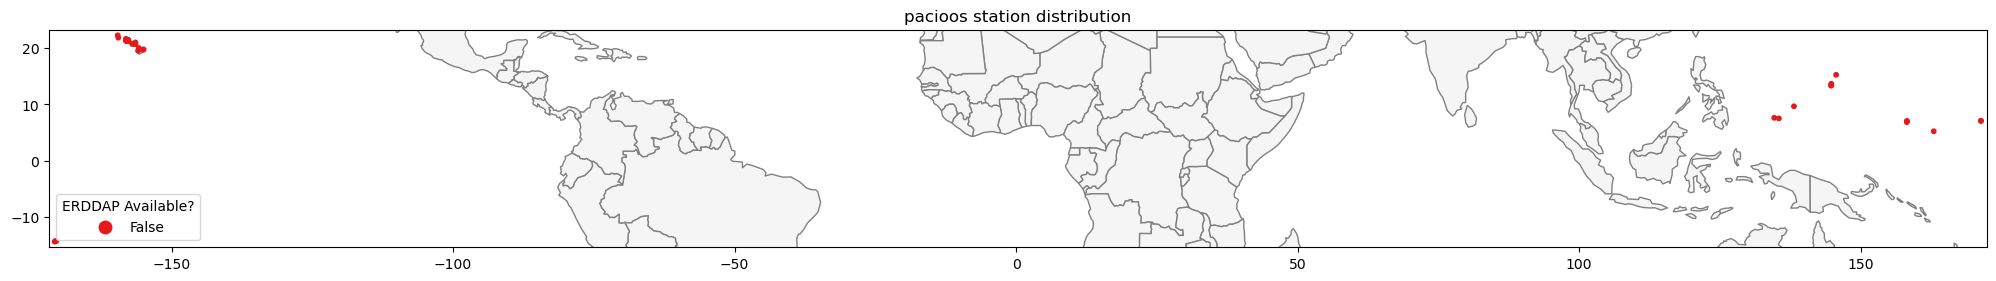

In [49]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [50]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1', style_kwds={"radius":5})


## Show me some bad coordinates

_if there are any_

In [51]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail


In [52]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [53]:
gdf_final.loc[~gdf_final['erddap_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
0,PACIOOS,AWS-HIMB,NaN,Coconut Island Weather Station,NaN,21.433,-157.7863,fixed,2005-01-01 00:00:00,Y,NaN,N,Hawaii Institute of Marine Biology,Academic,Hawaii Institute of Marine Biology,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.,POINT (-157.78630 21.43300),False
1,PACIOOS,WS- Pier 1,NaN,Pier 1 Honolulu Weather Station,Davis Weather Station,21.2962,-157.8687,fixed,2019-08-14 00:00:00,Y,Hawaii Pilot's Assoc.,N,PacIOOS,Private/Academic,PacIOOS,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.,POINT (-157.86870 21.29620),False
2,PACIOOS,CDIP 098,51202,"Mokapu Point, Oahu, Hawaii",Datawell Waverider,21.415,-157.6783,wave_buoy,2000-08-09 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-157.67830 21.41500),False
3,PACIOOS,CDIP 106,51201,"Waimea Bay, Oahu, Hawaii",Datawell Waverider,21.6705,-158.1172,wave_buoy,2001-12-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-158.11720 21.67050),False
4,PACIOOS,CDIP 121,52200,"Ipan, Guam",Datawell Waverider,13.3542,144.7883,wave_buoy,2003-07-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (144.78830 13.35420),False
5,PACIOOS,CDIP 163,52201,"Kalo, Majuro, Marshall Islands",Datawell Waverider,7.0835,171.3918,wave_buoy,2016-05-04 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (171.39180 7.08350),False
6,PACIOOS,CDIP 187,51205,"Pauwela, Maui, Hawaii",Datawell Waverider,21.0182,-156.4252,wave_buoy,2011-12-03 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-156.42520 21.01820),False
7,PACIOOS,CDIP 188,51206,"Hilo, Hawaii",Datawell Waverider,19.78,-154.97,wave_buoy,2012-03-04 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Due to be redeployed in May 2024;,POINT (-154.97000 19.78000),False
8,PACIOOS,CDIP 189,51209,"Aunuu, American Samoa",Datawell Waverider,-14.2645,-170.4934,wave_buoy,2014-10-23 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Due to be redeployed in May 2024;,POINT (-170.49340 -14.26450),False
9,PACIOOS,CDIP 196,52202,"Ritidian Point, Guam",Datawell Waverider,13.6837,144.8121,wave_buoy,2012-10-20 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Replacement buoy on-site. Waiting on weather ...,POINT (144.81210 13.68370),False


# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [54]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]

for station in gdf_ckan['Station ID'].dropna():

    RA = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('Station "{}" + RA "{}"'.format(station.lower(), RA.lower()))
    
    # build RA tag query
    fq = '+organization:{}'.format(RA.lower())

    # build free text query
    q = "\""+station.lower()+"\""+" -glider"

    query = ioos_catalog.address + '/dataset/?' + 'q=' + q + '&organization=' + RA.lower()
    
    print('Query: {}'.format(query.replace(" ","%20")))

    datasets = ioos_catalog.action.package_search(q=q, fq=fq)

    

    if datasets['count'] > 0:
        print('\tfound {} dataset(s):'.format(datasets['count']))
        
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            
            
            if dataset['resources']:
                print('\t',dataset['resources'][0]['url'])

                start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
                end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']

                print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')

                if 'thredds' in dataset['resources'][0]['url']:
                    ds = xr.open_dataset(dataset['resources'][0]['url'])

                    time_max = ds.time.max().values

                    time_min = ds.time.min().values


                    print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')

                    if pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                        test_date = pd.to_datetime(time_max, utc=True)

                else:
                    test_date = pd.to_datetime(end_date, utc=True)

                if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                    print('\t{} is valid.'.format(station))
                    break
                else:
                    print('\t{} is not valid.'.format(station))

                    problem_datasets.append(station)
            
            else:
                print('\t{} missing additional metadata'.format(station))
                problem_datasets.append(station)
    else:
        print("\tNo datasets found!")
        problem_datasets.append(station)

Station "aws-himb" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="aws-himb"%20-glider&organization=pacioos
	found 1 dataset(s):
	 HIMB Weather Station: Moku o Loe (Coconut Island), Oahu, Hawaii
	 https://pae-paha.pacioos.hawaii.edu/erddap/tabledap/aws_himb
	 Coverage Meta:
		 2005-01-01T10:00:00Z  -  2025-02-21T10:00:00Z 

	AWS-HIMB is valid.
Station "ws- pier 1" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="ws-%20pier%201"%20-glider&organization=pacioos
	No datasets found!
Station "cdip 098" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="cdip%20098"%20-glider&organization=pacioos
	No datasets found!
Station "cdip 106" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="cdip%20106"%20-glider&organization=pacioos
	No datasets found!
Station "cdip 121" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="cdip%20121"%20-glider&organization=pacioos
	No datasets found!
Station "cdip 163" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="cdip%20163"%20-glid

c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'ssh' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'u' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'v' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


	Coverage Data:
		 2024-12-01T00:00:00.000000000  -  2025-12-31T23:00:00.000000000 

	PP07 is not valid.
	 Tide Model for the Hawaiian Islands: Main NW Islands
	 https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/tide_mhi
	 Coverage Meta:
		 2024-12-01T00:00:00Z  -  2025-12-31T23:00:00Z 



c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'ssh' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'u' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'v' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


	Coverage Data:
		 2024-12-01T00:00:00.000000000  -  2025-12-31T23:00:00.000000000 

	PP07 is not valid.
Station "pp08" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="pp08"%20-glider&organization=pacioos
	found 6 dataset(s):
	 PacIOOS Water Quality Sensor Partnership Program 002: Kephara, Pohnpei, FSM
	 https://pae-paha.pacioos.hawaii.edu/erddap/tabledap/nss_wqspp_002
	 Coverage Meta:
		 2015-11-22T06:00:05Z  -  2017-06-18T23:00:05Z 

	PP08 is not valid.
	 PacIOOS Water Quality Sensor Partnership Program 003: Palmyra Atoll
	 https://pae-paha.pacioos.hawaii.edu/erddap/tabledap/nss_wqspp_003
	 Coverage Meta:
		 2017-10-02T21:28:55Z  -  2018-10-04T01:49:05Z 

	PP08 is not valid.
	 PacIOOS Water Quality Sensor Partnership Program 005: Kahala, Oahu, Hawaii
	 https://pae-paha.pacioos.hawaii.edu/erddap/tabledap/nss_wqspp_005
	 Coverage Meta:
		 2018-09-15T01:00:12Z  -  2020-01-31T11:36:11Z 

	PP08 is not valid.
	 PacIOOS Water Quality Sensor Partnership Program 004: Kewalo Basin, Oahu

c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'ssh' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'u' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'v' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


	Coverage Data:
		 2024-12-01T00:00:00.000000000  -  2025-12-31T23:00:00.000000000 

	PP08 is not valid.
	 Tide Model for the Hawaiian Islands: Main NW Islands
	 https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/tide_mhi
	 Coverage Meta:
		 2024-12-01T00:00:00Z  -  2025-12-31T23:00:00Z 



c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'ssh' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'u' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'v' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


	Coverage Data:
		 2024-12-01T00:00:00.000000000  -  2025-12-31T23:00:00.000000000 

	PP08 is not valid.
Station "pp09" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="pp09"%20-glider&organization=pacioos
	found 6 dataset(s):
	 PacIOOS Water Quality Sensor Partnership Program 002: Kephara, Pohnpei, FSM
	 https://pae-paha.pacioos.hawaii.edu/erddap/tabledap/nss_wqspp_002
	 Coverage Meta:
		 2015-11-22T06:00:05Z  -  2017-06-18T23:00:05Z 

	PP09 is not valid.
	 PacIOOS Water Quality Sensor Partnership Program 003: Palmyra Atoll
	 https://pae-paha.pacioos.hawaii.edu/erddap/tabledap/nss_wqspp_003
	 Coverage Meta:
		 2017-10-02T21:28:55Z  -  2018-10-04T01:49:05Z 

	PP09 is not valid.
	 PacIOOS Water Quality Sensor Partnership Program 005: Kahala, Oahu, Hawaii
	 https://pae-paha.pacioos.hawaii.edu/erddap/tabledap/nss_wqspp_005
	 Coverage Meta:
		 2018-09-15T01:00:12Z  -  2020-01-31T11:36:11Z 

	PP09 is not valid.
	 PacIOOS Water Quality Sensor Partnership Program 004: Kewalo Basin, Oahu

c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'ssh' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'u' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'v' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


	Coverage Data:
		 2024-12-01T00:00:00.000000000  -  2025-12-31T23:00:00.000000000 

	PP09 is not valid.
	 Tide Model for the Hawaiian Islands: Main NW Islands
	 https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/tide_mhi
	 Coverage Meta:
		 2024-12-01T00:00:00Z  -  2025-12-31T23:00:00Z 



c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'ssh' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'u' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'v' has multiple fill values {-999.99, -999.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


	Coverage Data:
		 2024-12-01T00:00:00.000000000  -  2025-12-31T23:00:00.000000000 

	PP09 is not valid.
Station "cwb-a" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="cwb-a"%20-glider&organization=pacioos
	No datasets found!
Station "cwb-b" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="cwb-b"%20-glider&organization=pacioos
	No datasets found!
Station "cwb-c" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="cwb-c"%20-glider&organization=pacioos
	No datasets found!
Station "wqb-04" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="wqb-04"%20-glider&organization=pacioos
	found 2 dataset(s):
	 PacIOOS Water Quality Buoy 04: Hilo Bay, Big Island, Hawaii
	 https://pae-paha.pacioos.hawaii.edu/erddap/tabledap/wqb_04
	 Coverage Meta:
		 2010-10-23T10:00:00Z  -  2025-02-21T10:30:00Z 

	WQB-04 is valid.
Station "wqb-05" + RA "pacioos"
Query: https://data.ioos.us/dataset/?q="wqb-05"%20-glider&organization=pacioos
	found 2 dataset(s):
	 PacIOOS Water Quality Buoy 05: Pe

Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [55]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
1,PACIOOS,WS- Pier 1,NaN,Pier 1 Honolulu Weather Station,Davis Weather Station,21.2962,-157.8687,fixed,2019-08-14 00:00:00,Y,Hawaii Pilot's Assoc.,N,PacIOOS,Private/Academic,PacIOOS,PacIOOS,"air_temperature, rainfall_amount, wind_speed, ...",No WMO ID because asset is land-based.,POINT (-157.86870 21.29620),False
2,PACIOOS,CDIP 098,51202,"Mokapu Point, Oahu, Hawaii",Datawell Waverider,21.415,-157.6783,wave_buoy,2000-08-09 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-157.67830 21.41500),False
3,PACIOOS,CDIP 106,51201,"Waimea Bay, Oahu, Hawaii",Datawell Waverider,21.6705,-158.1172,wave_buoy,2001-12-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-158.11720 21.67050),False
4,PACIOOS,CDIP 121,52200,"Ipan, Guam",Datawell Waverider,13.3542,144.7883,wave_buoy,2003-07-15 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (144.78830 13.35420),False
5,PACIOOS,CDIP 163,52201,"Kalo, Majuro, Marshall Islands",Datawell Waverider,7.0835,171.3918,wave_buoy,2016-05-04 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (171.39180 7.08350),False
6,PACIOOS,CDIP 187,51205,"Pauwela, Maui, Hawaii",Datawell Waverider,21.0182,-156.4252,wave_buoy,2011-12-03 00:00:00,Y,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",NaN,POINT (-156.42520 21.01820),False
7,PACIOOS,CDIP 188,51206,"Hilo, Hawaii",Datawell Waverider,19.78,-154.97,wave_buoy,2012-03-04 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Due to be redeployed in May 2024;,POINT (-154.97000 19.78000),False
8,PACIOOS,CDIP 189,51209,"Aunuu, American Samoa",Datawell Waverider,-14.2645,-170.4934,wave_buoy,2014-10-23 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Due to be redeployed in May 2024;,POINT (-170.49340 -14.26450),False
9,PACIOOS,CDIP 196,52202,"Ritidian Point, Guam",Datawell Waverider,13.6837,144.8121,wave_buoy,2012-10-20 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Replacement buoy on-site. Waiting on weather ...,POINT (144.81210 13.68370),False
10,PACIOOS,CDIP 197,52211,"Tanapag, Saipan, CNMI",Datawell Waverider,15.2685,145.6623,wave_buoy,2012-10-24 00:00:00,O,PacIOOS,Yf,PacIOOS,Academic,PacIOOS,CDIP,"sea_surface_wave_significant_height, sea_surfa...",Buoy communications failure. Replacement buoy ...,POINT (145.66230 15.26850),False


Print out the available metadata from the IOOS Catalog for the last dataset.

In [56]:
dataset

{'author': None,
 'author_email': None,
 'creator_user_id': '0ea3933c-4674-41dd-a17d-bfbc8c99bd75',
 'id': '2d3b8bab-0cc1-4a2c-a70d-9f2fcfae7989',
 'isopen': False,
 'license_id': None,
 'license_title': None,
 'maintainer': None,
 'maintainer_email': None,
 'metadata_created': '2025-01-09T12:46:53.170617',
 'metadata_modified': '2025-01-09T12:46:53.170633',
 'name': 'mapco2-buoy-maihi-bay-hawaii-island-hawaii',
 'notes': "This buoy is located in Maihi Bay approximately 200 meters offshore of the west coast of Hawaii Island just south of Kahaluu-Keauhou in the State of Hawaii. It is moored in waters 15 m (50 ft) deep. Data are recorded every 3 hours and transmitted daily. This Moored Autonomous Partial Pressure of Carbon Dioxide (MAPCO2) buoy was primarily established to monitor ocean acidification within a tropical coral reef ecosystem in the Central Pacific, complementing a national array of moored carbon dioxide buoys across the Pacific, Atlantic, and Caribbean. Other important phys

In [ ]:
# GLOS special case as they provide ERDDAP ID

# for dataset in gdf_final.loc[(~gdf_final['erddap_avail'] & ~gdf_final['Dataset (ERDDAP) ID'].isna()),'Dataset (ERDDAP) ID'].tolist():
#     print(dataset)
#     e.dataset_id = dataset
    
#     e.constraints = {
#                  "time>=": "{}-01-01".format(cy)
#             }
        
#     e.variables = ['time']
    
#     try:
        
#         df_data = e.to_pandas(parse_dates=True)
        
#         string = '\tDate range: {} - {}'.format(df_data.min()[0],df_data.max()[0])
        
#         print(string)
        
#         if pd.to_datetime(df_data.max()[0], utc=True) > pd.to_datetime('{}-01-01'.format(cy), utc=True):
            
#             datasetid = gdf_final.loc[gdf_final['Dataset (ERDDAP) ID']==dataset,'Station ID'].tolist()[0]
            
#             problem_datasets.remove(datasetid)
        
#     except:
#         print('\tNo valid data')

In [ ]:
#gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]